Useful links

- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
- https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
- https://towardsdatascience.com/time-series-forecasting-with-rnns-ff22683bbbb0
- https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
- http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
- https://colah.github.io/posts/2015-09-NN-Types-FP/
- https://pytorch.org/docs/stable/nn.html#rnn

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

### Download India's data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
1,2020-01-31,0,0,0


### Italy's and Spain's data

In [3]:
it_df = pd.read_csv('csv/italy.csv')
print(it_df.sample())

es_df = pd.read_csv('csv/spain.csv')
print(es_df.sample())

          date  deceased  recovered  confirmed  active  daily
63  2020-04-24     25969    60498.0     192994  106527   3021
          date  deaths  recovered  confirmed  active  daily
14  2020-03-09    35.0        140       2277    2102    764


### Prep data

In [4]:
def get_rnn_dataset(series, seq_len):
    """get rnn training dataset, given a series and seq_len"""
    ip_seq = np.array(series[:-1], dtype=np.float32)
    op_seq = np.array(series[1:], dtype=np.float32)
    data_len = len(series) - 1

    ips = []
    ops = []
    for i in range(data_len - seq_len + 1):
        ip, op = ip_seq[i : i+seq_len], op_seq[i : i+seq_len]
        ips.append(ip)
        ops.append(op)
    ips = np.array(ips, dtype=np.float32)
    ops = np.array(ops, dtype=np.float32)

    # convert from numpy to torch
    ip_t = torch.from_numpy(ips)
    op_t = torch.from_numpy(ops)

    dataset = tdt.TensorDataset(ip_t, op_t)
    return dataset

# preprocess data: sma(6) and normalise by 10k
in_cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000
it_cnf = np.array(it_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000
es_cnf = np.array(es_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000

# Choose among India or Italy or Spain here
cnf = in_cnf # np.append(it_cnf, es_cnf)
SEQ_LEN = 5
dataset = get_rnn_dataset(cnf, SEQ_LEN)

seq_data_loader = tdt.DataLoader(dataset, shuffle=False, batch_size=1)
rnd_data_loader = tdt.DataLoader(dataset, shuffle=True, batch_size=1)

### Define NN and train

Epoch: 0 Iter:   0 Loss:  0.02202 Out:  4360.36 Ex:  3310.67
Epoch: 1 Iter:   0 Loss:  0.01819 Out:  1520.31 Ex:  163.00
Epoch: 2 Iter:   0 Loss:  0.02249 Out:  2007.60 Ex:  3553.83
Epoch: 3 Iter:   0 Loss:  0.00036 Out:  4103.72 Ex:  3912.17
Epoch: 4 Iter:   0 Loss:  0.00029 Out: -9.68 Ex:  12.50
Epoch: 5 Iter:   0 Loss:  0.00015 Out: -20.50 Ex:  10.50
Epoch: 6 Iter:   0 Loss:  0.00004 Out:  861.46 Ex:  928.33
Epoch: 7 Iter:   0 Loss:  0.00030 Out:  5157.41 Ex:  5394.67
Epoch: 8 Iter:   0 Loss:  0.00008 Out:  3771.95 Ex:  3726.17
Epoch: 9 Iter:   0 Loss:  0.00002 Out:  639.84 Ex:  693.33
Epoch: 10 Iter:   0 Loss:  0.00001 Out:  163.99 Ex:  221.50
Epoch: 11 Iter:   0 Loss:  0.00011 Out:  2655.11 Ex:  2723.33
Epoch: 12 Iter:   0 Loss:  0.00001 Out:  915.38 Ex:  928.33
Epoch: 13 Iter:   0 Loss:  0.00004 Out:  1662.06 Ex:  1664.50
Epoch: 14 Iter:   0 Loss:  0.00003 Out:  59.85 Ex:  125.83
Epoch: 15 Iter:   0 Loss:  0.00002 Out:  90.42 Ex:  46.17
Epoch: 16 Iter:   0 Loss:  0.00006 Out:  22

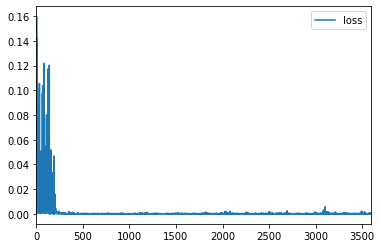

In [28]:
class Forecaster(tnn.Module):
    def __init__(self, seq_len=1, hidden_size=1, num_layers=1):
        super(Forecaster, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = tnn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.gru = tnn.GRU(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size, 1)
#         self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip, h=None):
        rnn_out, rnn_h = self.rnn(ip, h)
#         return (torch.squeeze(rnn_out), torch.squeeze(rnn_h))
        # linear layer
        final_out = []
        for i in range(self.seq_len):
            linear_out = self.linear(rnn_out[i].view(self.hidden_size))
            final_out.append(linear_out)
        return torch.stack(final_out).view(self.seq_len), rnn_h
    
    def predict(self, ip, num_predictions=1):
        preds = []
        with torch.no_grad():
            pred = ip
            h = None
            while(num_predictions):
                pred, h = self.forward(pred.view(self.seq_len, 1, 1), h)
                preds.append(pred.view(self.seq_len)[-1])
                num_predictions -= 1
        return torch.stack(preds)

HIDDEN_SIZE = 2
NUM_LAYERS = 1
LEARNING_RATE = 0.01

model = Forecaster(seq_len=SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

# TRAIN
loss_vals = []
pred_vals = []

NUM_EPOCHS = 50
for e in range(NUM_EPOCHS):
    for i, data in enumerate(rnd_data_loader):
        ip, op = data

        # set grads to 0
        optimizer.zero_grad()

        # predict
        pred, _ = model(ip.view(SEQ_LEN, 1, 1))

        # calc loss
        loss = loss_fn(pred, op.view(SEQ_LEN))

        # logging
        loss_vals.append(loss.item())
        if i == 0:
            print("Epoch:", e, "Iter:", f"{i:3}", "Loss:", f"{loss.item(): .5f}", "Out:", f"{pred.view(SEQ_LEN)[-1].item()*10000: .2f}", "Ex:", f"{op.view(SEQ_LEN)[-1].item()*10000: .2f}")

        # assign grads
        loss.backward()

        # update weights
        optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

### Test
- future values on any country's data

IN: tensor([5025.5000, 5394.6670, 5690.6665, 5819.0000, 6116.7500])
OUT: tensor([6229.1216, 6323.1616, 6400.6724, 6463.8374, 6514.8232, 6555.6558,
        6588.1479, 6613.8716, 6634.1519, 6650.0898, 6662.5825, 6672.3555,
        6679.9883, 6685.9429, 6690.5845, 6694.1992, 6697.0132, 6699.2031,
        6700.9067, 6702.2319, 6703.2622, 6704.0640, 6704.6870, 6705.1714,
        6705.5483, 6705.8418, 6706.0703, 6706.2480, 6706.3862, 6706.4937,
        6706.5771, 6706.6426, 6706.6934, 6706.7324, 6706.7637, 6706.7881,
        6706.8066, 6706.8213, 6706.8325, 6706.8418, 6706.8481, 6706.8540,
        6706.8584, 6706.8618, 6706.8643, 6706.8662, 6706.8677, 6706.8691,
        6706.8696, 6706.8701])


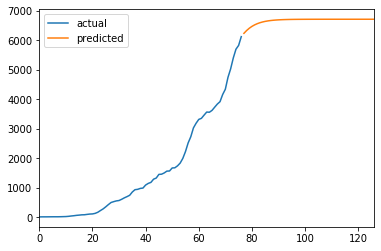

In [29]:
# CHOOSE FROM IN, IT OR ES HERE
df_cnf = in_cnf
# df_cnf = np.array([8000, 7600, 7300, 6900, 6650], dtype=np.float32) / 10000

test_in = df_cnf[-SEQ_LEN:]
t = torch.tensor(
    test_in.reshape(SEQ_LEN, 1, 1),
    dtype=torch.float32
)
print("IN:", t.view(SEQ_LEN) * 10000)
out = model.predict(t, num_predictions=50)
print("OUT:", out * 10000)

orig_df = pd.DataFrame({
    'actual': df_cnf * 10000
})
fut_df = pd.DataFrame({
    'predicted': (out.numpy() * 10000)
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
_ = orig_df.plot()

- on training data

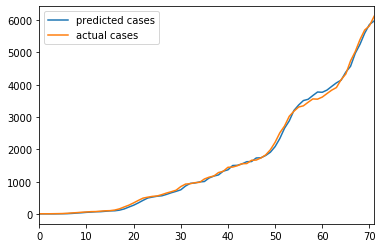

In [30]:
pred_vals = []
out_vals = []
for data in seq_data_loader:
    ip, op = data
    pred = model.predict(ip.view(SEQ_LEN, 1, 1))
    pred_vals.append(pred.item() * 10000)
    out_vals.append(op.view(SEQ_LEN)[-1].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
_ = cmp_df.plot()

In [31]:
for k in model.state_dict().keys():
    print(k, "=", model.state_dict()[k])

rnn.weight_ih_l0 = tensor([[-1.4046],
        [-1.1551]])
rnn.weight_hh_l0 = tensor([[-0.2088,  0.2843],
        [ 0.2955, -0.4304]])
rnn.bias_ih_l0 = tensor([0.1908, 0.6346])
rnn.bias_hh_l0 = tensor([ 0.0838, -0.2946])
linear.weight = tensor([[-0.5144, -0.3218]])
linear.bias = tensor([0.2418])
